In [1]:
import json
import numpy as np
import pickle

FILE_PATH = '/home/eunbijang/gallery/solvation_compound/pampa_json/'
sol_params = json.load(open(FILE_PATH + 'heptamer.averaged.json'))

# Define solvation atom types
sol_types = []

for molname in sol_params.keys():
    sol_param = sol_params[molname]
    occ = sol_param['occ']
    sol_types.extend(list(occ.keys()))
    sol_types = list(set(sol_types))

sol_types.sort()
sol_types.insert(0, 'vol')

# Vectorize occupancies
# P1393 P1982 P2118 P2208 : None for logp

features = []
molnames = []
none_list = ['P1393', 'P1982', 'P2118', 'P2208']


for molname in sol_params.keys():
    if molname not in none_list:
        sol_param = sol_params[molname]
        occ = sol_param['occ']
        feature = []
        feature.append(float(sol_param['volume']))

        for sol_type in sol_types[1:]:
            feature.append(float(occ[sol_type]) if sol_type in occ.keys() else 0.0)

        features.append(feature)
        molnames.append(molname)
        
with open('molnames.txt', 'w') as fw:
    for molname in molnames:
        fw.write(molname)
        fw.write('\n')
        
        
features_np = np.array(features)

features_tr = np.transpose(features_np)

feature_std_params = []

for fi, feature_tr in enumerate(features_tr):
    avg = np.average(feature_tr)
    stddev = np.std(feature_tr)
    features_tr[fi] = (feature_tr - avg)/stddev

    feature_std_params.append({'type':sol_types[fi], 'avg':avg, 'stddev':stddev})

features_std = np.transpose(features_tr)


features_std.shape




(1470, 11)

In [2]:
#smiles_vector = np.load("vector_save.npy", allow_pickle = True)
with open('vector.pickle', 'rb') as fr:
    smiles_vector = pickle.load(fr)

smiles_vector = np.array(smiles_vector)

In [2]:
import pandas as pd

col_list = []

for i in range(300):
    num = str(i).zfill(3)
    #df2 = df.loc[:,f'mol2vec-{num}']
    col_list.append(f'mol2vec-{num}')
    
df = pd.read_csv('new.csv', usecols=col_list)
df.iloc[1 :4]
df.loc[1]

mol2vec-000     3.679465
mol2vec-001   -10.426257
mol2vec-002    -7.242497
mol2vec-003    13.376564
mol2vec-004     1.219783
                 ...    
mol2vec-295   -19.978807
mol2vec-296   -12.117805
mol2vec-297   -13.657086
mol2vec-298   -34.166504
mol2vec-299    -2.242384
Name: 1, Length: 300, dtype: float64

In [46]:
vect = (df.loc[0]).tolist()
vect = np.array(vect)
features_std[0]
len(np.concatenate((vect,features_std[0]), axis = 0))

311

In [47]:
extended_features = []
for i in range(len(features_std)):
    vect = (df.loc[i]).tolist()
    vect = np.array(vect)   
    extended_features.append(np.concatenate((vect,features_std[i]), axis = 0))

In [83]:
extended_features = np.array(extended_features)
extended_features.shape

(1470, 311)

In [84]:
#extended_features[1469]

In [4]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components =10)

# reducted_smi = []

# for i, smi in enumerate(smiles_vector): # [0.0]으로 들어간건 ...?
#     X = np.empty((300, 140))
#     for j, vec in enumerate(smi):
#         X[:,j] = vec
#     # print(X.shape) (300, 140)
#     result = pca.fit_transform(np.transpose(X)) 
#     # print(result.shape)(140, 10) 
   
#     reducted_smi.append(result)
    
# extended_features = []

# for idx, vec in enumerate(reducted_smi):
#     vec = list(vec)
#     vec.append(features_std[idx])
#     reducted_smi[idx] = vec
   
#     #extended_features.append(np.array(vec, dtype=object))

    



In [13]:
with open('molnames', 'w') as f:
    for m in molnames:
        f.write(m)
        f.write('\n')

In [79]:
# Read experimental values for solvation energy 

sol_exp_dict = {}
sol_exp_list = []

with open('/home/eunbijang/gallery/solvation_compound/jupyter_notebook/logp.txt') as f:
    values = f.readlines()
    for idx, val in enumerate(values):
        values[idx] = val.strip()
    
    for i,logp in enumerate(values):
        # if logp != 'None':
        #     sol_exp_dict[molnames[i]] = float(logp)
        # else:
        #     print(molnames[i])
        #     sol_exp_dict[molnames[i]] = float(0.0)
        sol_exp_dict[molnames[i]] = float(logp)

sol_exp = np.array([sol_exp_dict[m] for m in molnames])

# Standardize experimental values
sol_avg = np.average(sol_exp)
sol_std = np.std(sol_exp)
sol_exp_std = (sol_exp - sol_avg)/sol_std

len(sol_exp_std)




1470

In [85]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def train_model(features, values, epochs):
    #print(len(features[0]))
    model = keras.Sequential([
    # data flatten 
    keras.layers.Dense(64, input_dim=len(features[0]), activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, input_dim=len(features[0]), activation='relu', kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

   
    keras.layers.Dense(1, activation='linear')
    ])

    optimizer = 'adam'
    #optimizer = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    #optimizer = tf.keras.optimizers.RMSprop(0.00005)
    model.compile(optimizer=optimizer,
                loss='mse'); 

    hist = model.fit(features, values, epochs=epochs, verbose=1, batch_size=64)
    #SVG(model_to_dot(model, show_shapes=True, dpi=65, ).create(prog='dot', format='svg'))
    model.summary()
    return model, hist
    



In [64]:
from scipy.stats.stats import pearsonr


def evaluate(model, features, values):
    preds = model.predict(features)
    r = pearsonr([p[0] for p in preds], values)

    return r
 

def print_pred(features_std, molnames, preds, sol_exp, sol_avg, sol_std):
    preds = model.predict(features_std)

    for molname, p, s in zip(molnames, preds, sol_exp):
        print ("%10s %12f %12f" % (molname, p * sol_std + sol_avg, s))

    r = pearsonr([p[0] for p in preds], sol_exp_std)
    print (r[0]**2)

In [96]:
from sklearn.model_selection import KFold


def cross_validate(split_size, features):
    models = []
    corr_coeffs = []
   
    test_idx = []
    train_idx = []
   
    prediction_test = []
    prediction_train = []
    hist_list = []
    kf = KFold(n_splits = split_size, shuffle=True)

    for train_index, test_index in kf.split(features):
        train_data = np.array([extended_features[ti] for ti in train_index])
        train_sol = np.array([sol_exp_std[ti] for ti in train_index])
        # train_data = np.asarray(train_data)
        # train_sol = np.asarray(train_sol)
        
        model, hist = train_model(train_data, train_sol, epochs=100)

        test_data = np.array([extended_features[ti] for ti in test_index])
        test_sol = np.array([sol_exp_std[ti] for ti in test_index])

        corr_coeff = evaluate(model=model,features=test_data, values=test_sol)
        preds_train = model.predict(train_data) #테스트 데이터 predict 해서 나중에 sol이랑 비교
        preds_test = model.predict(test_data)
        
        prediction_train.append(preds_train)
        prediction_test.append(preds_test)
        corr_coeffs.append(corr_coeff)

        models.append(model)
  
        test_idx.append(test_index)
        train_idx.append(train_index)

    return corr_coeffs, models, train_idx, test_idx, prediction_train, prediction_test, hist



In [93]:
corr_coeffs, models, train_idx, test_idx, prediction_train, perdiction_test, history = cross_validate(split_size=10, features=features_std)

[ 3.67946480e+00 -1.04262570e+01 -7.24249740e+00  1.33765640e+01
  1.21978340e+00 -9.56539200e+00 -2.33544580e+01 -3.90578340e+00
  1.82615870e+01 -7.18438530e+00  1.11640470e+01  1.33434900e+01
  3.86665940e+00  9.57248700e+00 -2.34776520e+01 -8.73375800e+00
  1.83797130e+01 -1.77526340e+01 -2.11568550e+01  2.46564800e+01
  5.26779460e+00  1.62440150e+01  3.73422160e+01  1.64569720e+01
 -1.49058190e+01  4.69367100e+00 -1.12042230e+01 -3.30072480e+01
  3.22947810e+00 -9.68066800e+00  1.55249740e+01 -6.10804100e+00
 -1.92818410e+01 -1.62369350e+00  4.25130500e+00  7.69454960e+00
  7.47401050e+00 -3.39143590e+00  1.88471800e+01  1.00525040e+01
 -3.55296800e+00 -5.72451450e+00 -2.98956920e+00 -1.15137340e+01
 -2.03386200e+01  1.72525650e+01 -8.54062860e-01  1.96631900e+01
 -3.73859980e+00  5.69119000e-01  1.05829330e+01 -2.20014610e+01
 -5.54795600e-01 -1.09080800e+01 -2.78453790e+01 -1.28268350e+01
 -1.03487230e+01  1.13987470e+01  5.96758800e+00  8.61302950e+00
  3.63271210e+00 -1.36313

/home/eunbijang/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [67]:
print (corr_coeffs)

[(nan, nan), (nan, nan), (nan, nan), (nan, nan), (0.2979687695900886, 0.0002468949816130138), (-0.025094950704892524, 0.76287298667261), (nan, nan), (0.031583089302605165, 0.7041307035826954), (-0.00509573732725838, 0.951155731378174), (nan, nan)]


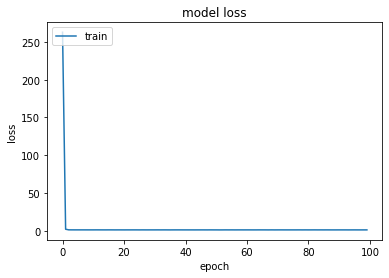

In [95]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 

In [ ]:
[c[0] for c in corr_coeffs]

In [ ]:
([c[0]**2 for c in corr_coeffs])

In [ ]:
models[1]

In [ ]:
molname_list = np.array([new_molnames[ti] for ti in train_idx[8]])
len(molname_list)

In [ ]:
pp = []
ss = []
mm = []
for molname, p, s in zip(molname_list, prediction_train[8], sol_exp[train_idx[8]]):
    pp.append(p * sol_std+ sol_avg)
    ss.append(s)
    mm.append(molname)
    print ("%10s %12f %12f" % (molname, p * sol_std + sol_avg, s))

In [ ]:
import csv
with open("/home/eunbijang/solvation_compound/prediction_values_train.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["# molname ", "predicted_value", "actual_value"])
    for i in range(len(pp)):
        f_list = [mm[i], pp[i], ss[i]]
        writer.writerow(f_list)


In [ ]:
# Standardize experimental values

# sol_avg = np.average(sol_exp)
# sol_std = np.std(sol_exp)
# sol_exp_std = (sol_exp - sol_avg)/sol_std

test = (prediction*sol_std)
test += sol_avg



In [ ]:
import matplotlib.pyplot as plt
#plt.scatter(test_index, test, c = 'red')
x = [-15,-12.5,-10,-7.5-5,-2.5,0,2.5,5]
y = [-15,-12.5,-10,-7.5-5,-2.5,0,2.5,5]
hfont = {'fontname':'Helvetica'}
plt.scatter(pp, ss)
plt.xlim(-15.5 , 5.5)
plt.ylim(-15.5 , 5.5)
plt.xlabel('Prediction (kcal/mol)', **hfont)
plt.ylabel('Experiment (kcal/mol)', **hfont)
plt.text(-15, 2.5,"r^2:0.9", fontsize=20)
plt.plot(x,y, c="red")
plt.show()


In [ ]:
# x = [-15,-12.5,-10,-7.5-5,-2.5,0,2.5,5]
# y = [-15,-12.5,-10,-7.5-5,-2.5,0,2.5,5]
plt.scatter(train_sol, sol_exp[train_idx[0]])
plt.xlabel('Train (kcal/mol)')
plt.ylabel('Experiment (kcal/mol)')
#plt.plot(x,y, c="red")
plt.show()


In [ ]:
plt.scatter(train_idx[3], pp, c = 'red')
plt.scatter(train_idx[3], sol_exp[train_idx[3]])
plt.show()


In [ ]:
# Save models

from datetime import datetime
import json

now = datetime.now()

dtsstr = now.strftime("%m%d%Y%H%M%S")

for mi, model in enumerate(models):
    filename = 'model.%s.%02d.h5' % (dtsstr, mi)
    model.save(filename)

sol_feat_params = {'feat_norm_params':feature_std_params, 'R^2':corr_coeffs}

with open('model.%s.param.json' % (dtsstr), 'w') as fw:
    print(json.dumps(sol_feat_params, indent=4), file=fw)


In [ ]:
import json
import numpy as np
sol_params = json.load(open('chembl.json'))

# Vectorize occupancies
features = []
molnames = []
for molname in sol_params.keys():
    sol_param = sol_params[molname]
    occ = sol_param['occ']
    feature = []
    feature.append(float(sol_param['volume']))

    for sol_type in feature_std_params[1:]:
        type = sol_type["type"]
        avg = float(sol_type["avg"])
        std = float(sol_type["stddev"])

        if type in occ.keys():
            feature.append((float(occ[type])- avg)/std)
        else:
            feature.append(0.0)

    features.append(feature)
    molnames.append(molname)

features_std = np.array(features)

features_std.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for model in models:
    pred = model.predict(test_data)
    print(pred[0])
   
    

In [ ]:
print(len(models))

In [ ]:
plt.figure()

plt.scatter(test_data, pred)

plt.show()

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()